In [13]:
%%capture
%run utils.py # Load auxiliary functions
# Show maps inline
from bokeh.resources import INLINE
import bokeh.io
bokeh.io.output_notebook(INLINE)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install scienceplots
import scienceplots
plt.style.use('nature')

In [2]:
##################################################
# load network-data into L-space and P-space graph
##################################################

graph = load_gtfs("./vienna.sqlite")
L = load_graph("./vienna.pkl")
P = P_space(graph,
                  L,
                  start_hour=5, # Same as when building L-space
                  end_hour=24, # Same as when building L-space
                  mode="Subway") # Same as when building L-space

# calculate gtc to get in-vehicle time
alpha = 2 # Waiting time is multiplied by 2
betas = [5,15] # 5 minutes for the first transfer, 15 minutes for any transfer after that.
m = 1 # Number of shortest paths to retrieve
gtc = get_all_GTC(L, P, m, alpha, betas)

Using direction_id field as indicator for the direction of routes
180/98
900/98
860/98
2510/98
3330/98
All GTC computed!


In [3]:
##################################################
# calculate and set closeness centrality for nodes
##################################################

# calculate the degree centrality by nx
closenessL = dict(nx.closeness_centrality(G=L, distance=None))
closenessL = pd.DataFrame.from_dict(closenessL, orient='index')
closenessL.columns = ['closeness']

# calculate the degree centrality by nx
# closenessL = dict(nx.closeness_centrality(G=P, distance=None))
# closenessL = pd.DataFrame.from_dict(closenessL, orient='index')
# closenessL.columns = ['closeness']

# assign closeness attributes into network nodes:
nx.set_node_attributes(P, 0, "closeness")
num_row = closenessL.shape[0]
for row in range(num_row):
    node_idx = closenessL.index[row]
    val = closenessL['closeness'].iloc[row]
    P.nodes[node_idx]['closeness'] = val

# display node and edge attributes
list(P.edges(data=True))[0], list(P.nodes(data=True))[0]

((3913,
  2118,
  {'veh': {2: {'1': 13.157894736842104}},
   'avg_wait': 2.2800000000000002,
   'edge_color': '#E3000F'}),
 (3913,
  {'lat': 48.2775553655484,
   'lon': 16.4517820482664,
   'name': 'Leopoldau',
   'original_ids': [3913, 3912],
   'closeness': 0.060587133041848845}))

In [4]:
closenessL

,closeness
3913,0.060587
2118,0.064452
2113,0.068746
2124,0.073541
3562,0.078926
...,...
3075,0.083983
1435,0.077912
2494,0.072550
81,0.067785


In [5]:
###############
# calculate a_i
###############

# 1. calculate the Q: WHAT is Q??
Q = 10000
# 2. calculate the ratio of Ci / Σ Ci
summation = closenessL['closeness'].sum()
closenessL['Ratio'] = closenessL['closeness'] / summation

################
# calculate f_ij
################

# 1. calculate in-vehicle travel time t_ij
# create a in-vehicle travel time matrix (98 by 98)
Time_ij = np.zeros((98,98))
Time_ij = pd.DataFrame(data=Time_ij, index=gtc.keys(), columns=gtc.keys())
# set the value for each o-d pair
for origin, nodes in gtc.items():
    for destin, attr in nodes.items():
        Time_ij.at[origin, destin] = attr[0]['in_vehicle']
assert Time_ij.shape == (98, 98)
# 2. calculate Impedance matrix (98 by 98)
# f_ij = alpha * e^{-1*beta*t_ij} | Formula 2
alpha, beta = 5, 0.5
Impedance_ij = alpha * np.exp(-1*beta*Time_ij)
assert Impedance_ij.shape == (98, 98)

##########################
# calculate OD matrix x_ij
##########################

# create a OD matrix (98 by 98)
OD_ij = np.zeros((98,98))
OD_ij = pd.DataFrame(data=OD_ij, index=gtc.keys(), columns=gtc.keys())
assert OD_ij.shape == (98, 98)

# calculate the od pair trips production and attraction
for idx, origin in enumerate(gtc.keys()):
    for jdx, destin in enumerate(gtc.keys()):
        if idx != jdx:
            a_i, a_j = closenessL.loc[origin]['Ratio'], closenessL.loc[destin]['Ratio']
            f_ij = Impedance_ij.at[origin, destin]
            all_f = Impedance_ij.loc[origin].copy().to_numpy()
            all_a = closenessL['Ratio'].copy().to_numpy()
            all_a[idx] = 0
            assert all_f.shape == all_a.shape
            OD_ij.at[origin, destin] = Q * a_i * (a_j * f_ij) / (sum(all_a * all_f))

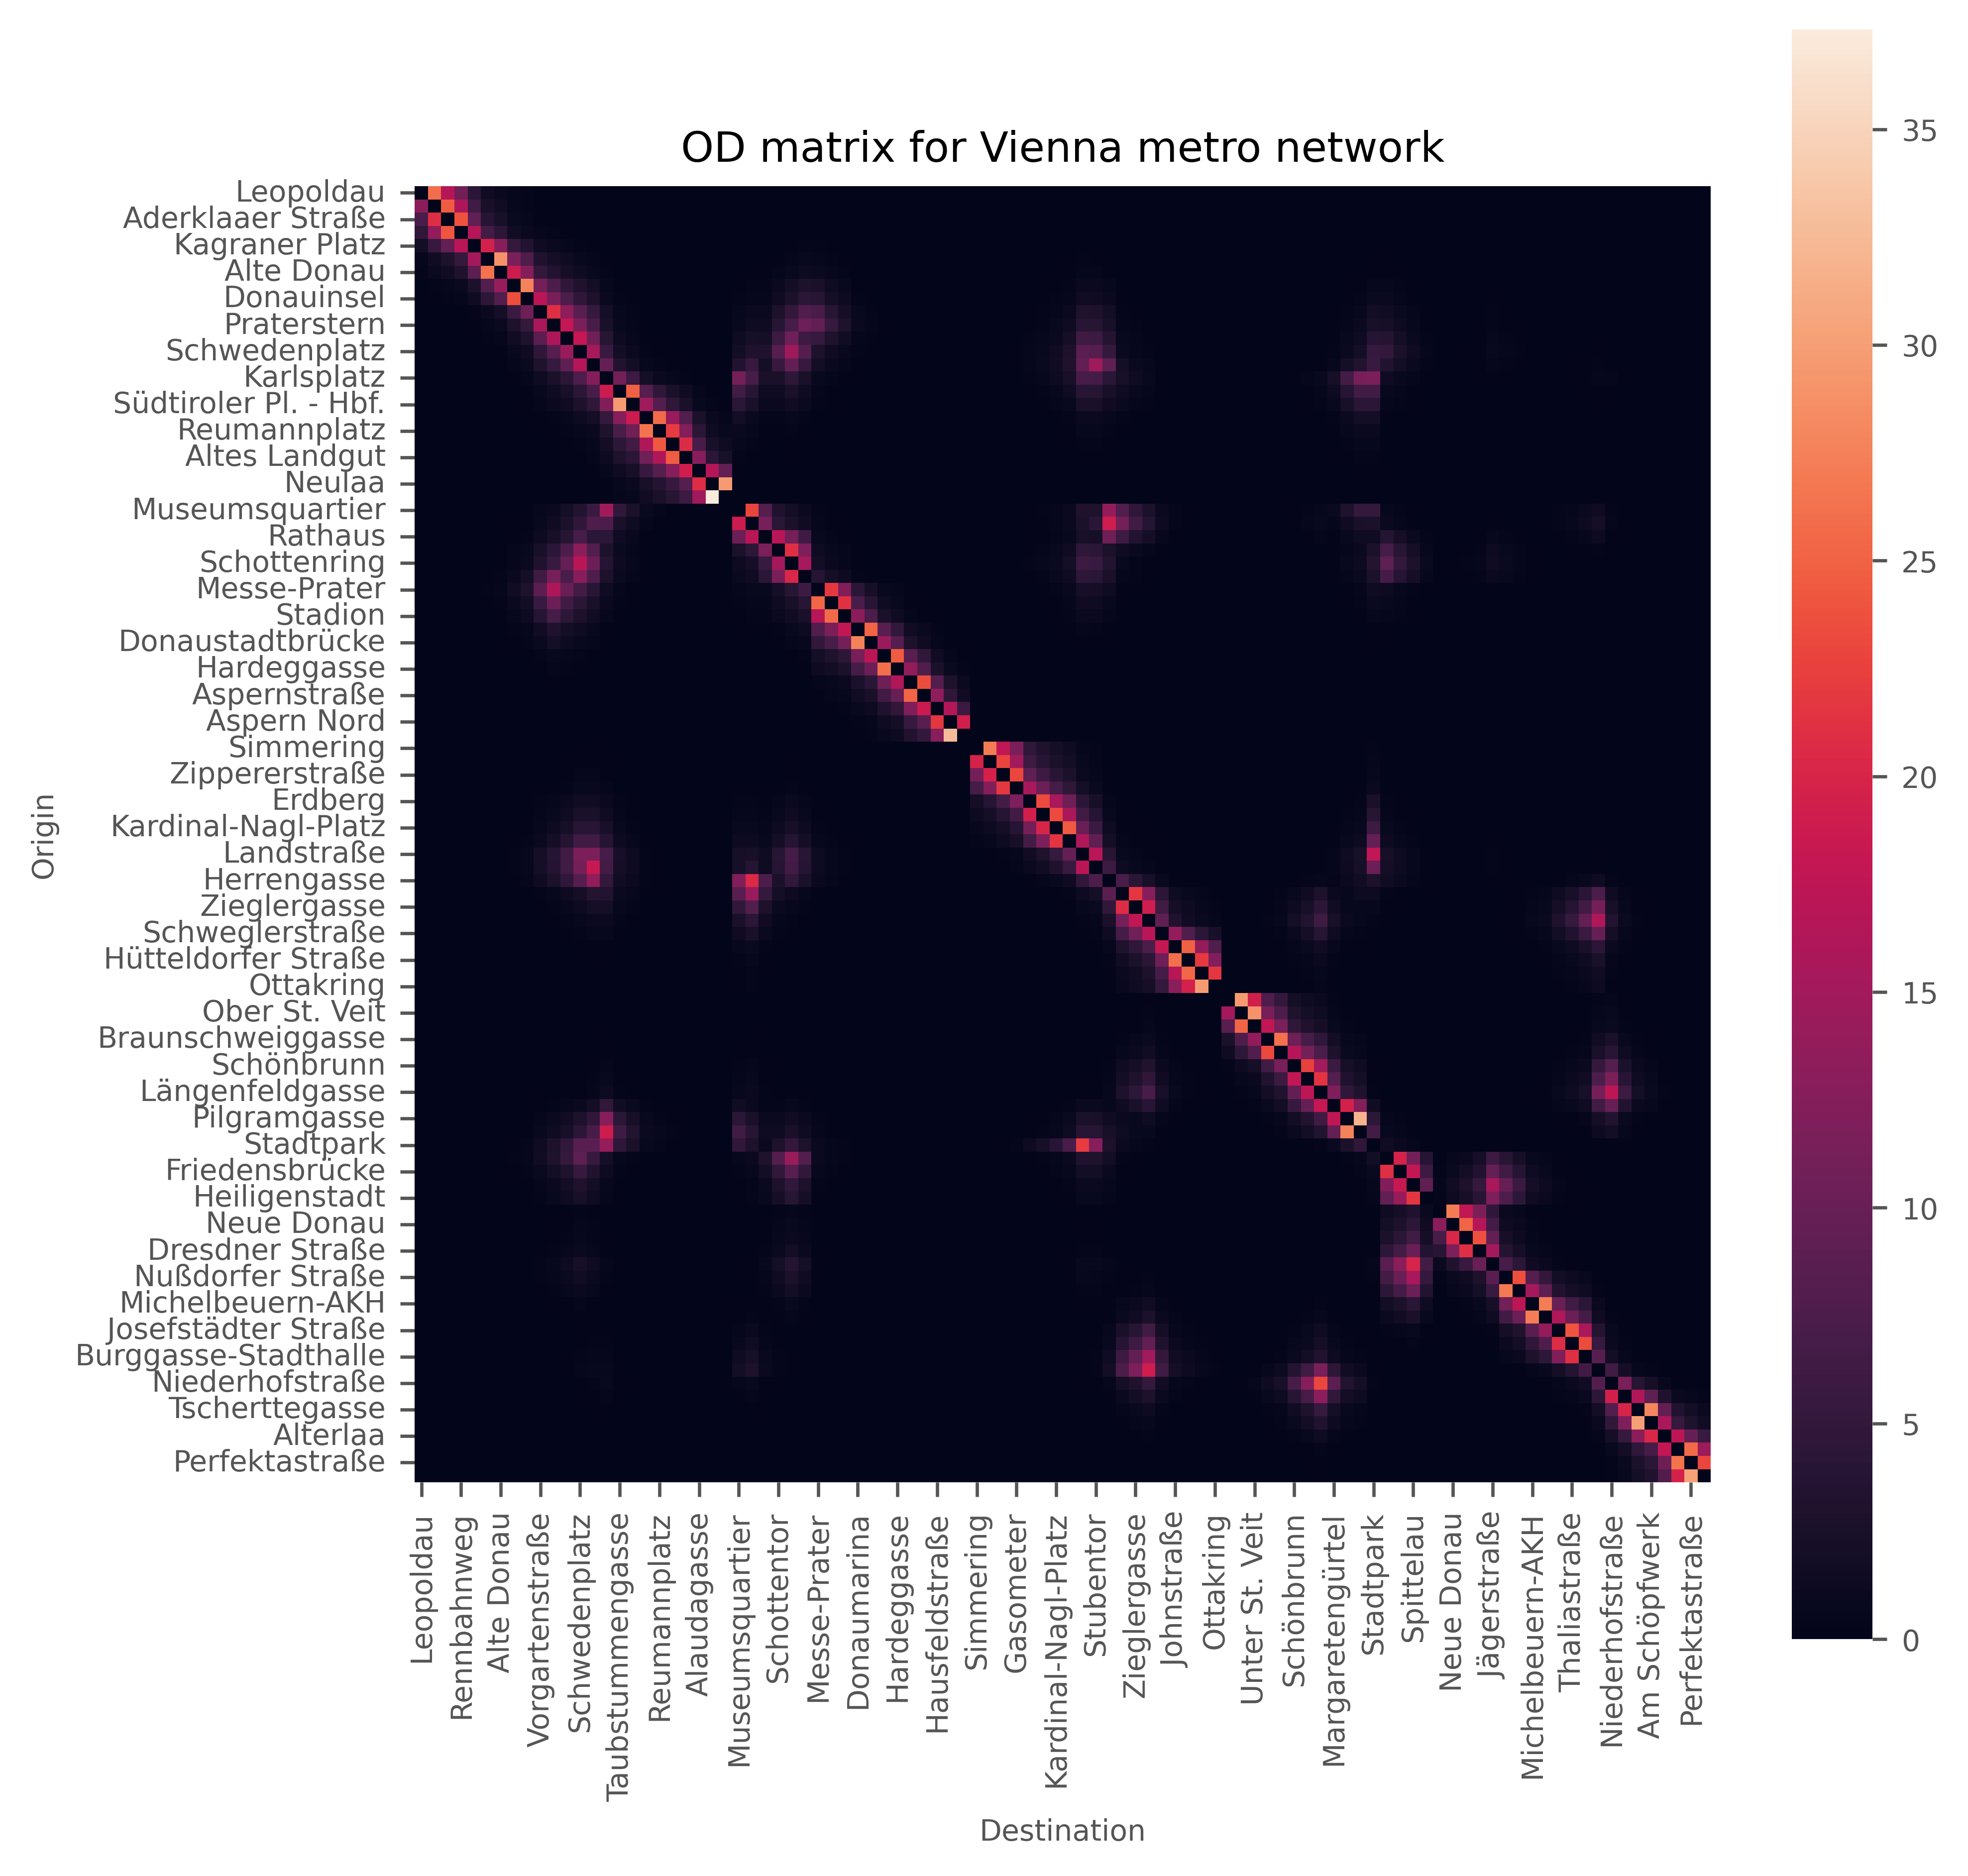

In [90]:
names = []
for no, attr in list(P.nodes(data=True)):
    names.append(attr['name'])
assert len(names) == 98
OD_ij.columns = names
OD_ij.index = names

fig = plt.figure(figsize=(7,7))
ax = sns.heatmap(data=OD_ij, 
                square=True,
                cbar=True,
            # annot=True, 
            # annot_kws={"size": 5},
            # fmt='2.0f',
           )
ax.set_title("OD matrix for Vienna metro network")
ax.set_ylabel("Origin")
ax.set_xlabel("Destination")
fig.savefig("./plots/OD_matrix.png", dpi=500)